# 目次

- 精度評価
- 特徴量重要度
- 特徴量エンジニアリング
- 再評価
- 特徴選択

# ライブラリ

In [2]:
# データ処理
import csv
import numpy as np
import pandas as pd
import scipy.stats as stats
pd.options.display.float_format = '{:.0f}'.format

# 描画
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style(style='dark')
from tqdm import tqdm # プログレスバー
mplstyle.use('fast')

# 表示調整
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP'] # 日本語対応
plt.rcParams["figure.figsize"] = [20,5] # 表示サイズ
plt.rcParams["font.size"] = 10 # 文字サイズ
# HTML対応
from IPython.core.display import display, HTML
# 全表示対応
display(HTML("<style>.cm-s-ipython span.cm-comment { color: blue; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# データ取得
boston_df = pd.read_csv("./boston.csv", sep=',')

In [4]:
# データ確認
boston_df.shape
boston_df.head()
boston_df.info()
boston_df.describe()

(506, 14)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0,18,2,0,1,7,65,4,1,296,15,397,5,24
1,0,0,7,0,0,6,79,5,2,242,18,397,9,22
2,0,0,7,0,0,7,61,5,2,242,18,393,4,35
3,0,0,2,0,0,7,46,6,3,222,19,395,3,33
4,0,0,2,0,0,7,54,6,3,222,19,397,5,36


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506,506,506,506,506,506,506,506,506,506,506,506,506,506
mean,4,11,11,0,1,6,69,4,10,408,18,357,13,23
std,9,23,7,0,0,1,28,2,9,169,2,91,7,9
min,0,0,0,0,0,4,3,1,1,187,13,0,2,5
25%,0,0,5,0,0,6,45,2,4,279,17,375,7,17
50%,0,0,10,0,1,6,78,3,5,330,19,391,11,21
75%,4,12,18,0,1,7,94,5,24,666,20,396,17,25
max,89,100,28,1,1,9,100,12,24,711,22,397,38,50


# 精度評価（データセットはそのまま）

In [5]:
from sklearn.ensemble import RandomForestRegressor as RFR # ランダム・フォレスト（回帰）
from sklearn.model_selection import train_test_split # データ分割
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error # 各評価指標

def learning(model, df):
    # データ分割
    X = df.drop('MEDV',axis=1)
    y = df['MEDV']
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 学習、予測
    rfr_model = model
    rfr_model.fit(X_train, y_train)
    y_pred = rfr_model.predict(X_test).round(decimals=1)

    # 評価    
    print('決定係数（R2） = ', r2_score(y_test, y_pred).round(decimals=3))
    print('平均絶対誤差（MAE） = ', mean_absolute_error(y_test, y_pred).round(decimals=3))
    print('平均二乗誤差（MSE） = ', mean_squared_error(y_test, y_pred).round(decimals=3))
    print('対数平均二乗誤差（MSLE） = ', mean_squared_log_error(y_test, y_pred).round(decimals=3))
    print('平均二乗平方根誤差（RMSE） = ', np.sqrt(mean_squared_error(y_test, y_pred)).round(decimals=3))
    print('対数平方平均二乗誤差（RMSLE） = ', np.sqrt(mean_squared_log_error (y_test, y_pred)).round(decimals=3))
    
    return rfr_model, y_test, y_pred

# 実行
rfr_model, y_test, y_pred = learning(RFR(random_state=42), boston_df)

決定係数（R2） =  0.892
平均絶対誤差（MAE） =  2.04
平均二乗誤差（MSE） =  7.902
対数平均二乗誤差（MSLE） =  0.02
平均二乗平方根誤差（RMSE） =  2.811
対数平方平均二乗誤差（RMSLE） =  0.142


非線形モデルでまずまずの評価

# 特徴量重要度

## ランダム・フォレストver

In [6]:
def rfr_importance(df):
    # データ分割
    X = df.drop(columns='MEDV', axis=1)
    y = df['MEDV']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # モデリング
    clf_rf = RFR()
    clf_rf.fit(X_train, y_train)
    y_pred = clf_rf.predict(X_test)

    # 評価
    print('平均二乗平方根誤差（RMSE） = {:>.3f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

    # 重要度
    fimp = clf_rf.feature_importances_

    # データフレームに変換
    imp_df = pd.DataFrame()
    imp_df['項目名'] = df.columns[:-1]
    imp_df['重要度'] = fimp.round(decimals=3).astype(str)
    
    return imp_df

# 実行
imp_df = rfr_importance(boston_df)
imp_df.sort_values(by='重要度', ascending=False)

平均二乗平方根誤差（RMSE） = 4.566


,項目名,重要度
5,RM,0.428
12,LSTAT,0.399
0,CRIM,0.045
7,DIS,0.037
10,PTRATIO,0.023
4,NOX,0.021
9,TAX,0.015
6,AGE,0.011
11,B,0.009
2,INDUS,0.006


## XGBoost ver

[15:44:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




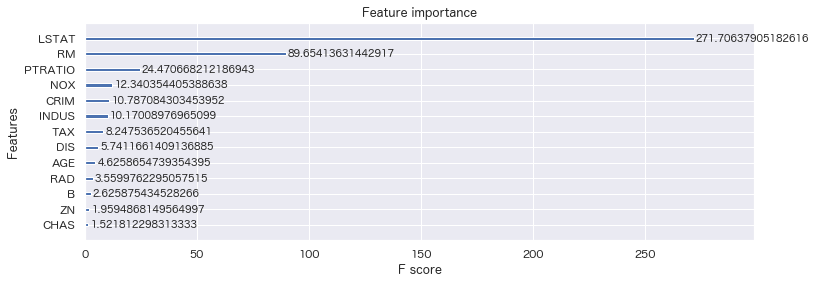

In [7]:
import xgboost as xgb

def boost_importance(df):
    # データ分割
    X = df.drop(columns='MEDV', axis=1)
    y = df['MEDV']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # パラメータ
    xgb_params = {"objective": "reg:linear", "eta": 0.1, "max_depth": 6, "silent": 1}
    num_rounds = 100

    # XGBoost用のデータセットの作成
    dtrain = xgb.DMatrix(X_train, label=y_train)

    # 学習
    gbdt = xgb.train(xgb_params, dtrain, num_rounds)

    # 重要度
    _, ax = plt.subplots(figsize=(12, 4))
    # パラメーター：gain 予測精度をどれだけ改善させたることができるできたか（平均値）
    xgb.plot_importance(gbdt, ax=ax, importance_type='gain')
    
# 実行
boost_importance(boston_df)

## 線形回帰モデル ver

スコア： 4.926
選択項目数： 11、除外項目数： 2


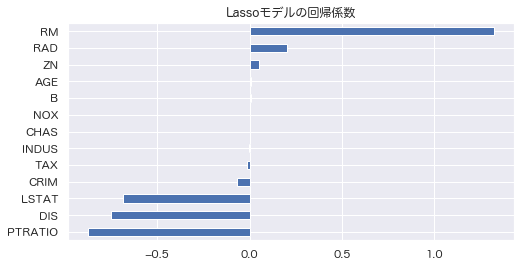

In [8]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def linear_importance(df):
    X = df.drop(columns='MEDV', axis=1)
    y = df['MEDV']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    def rmse_cv(model):
        rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
        return(rmse)

    # model_ridge = Ridge().fit(X_train, y_train)
    model_lasso = LassoCV().fit(X_train, y_train)
    print(f'スコア： {rmse_cv(model_lasso).mean().round(decimals=3)}')

    coef = pd.Series(model_lasso.coef_, index = X_train.columns)
    print("選択項目数： " + str(sum(coef != 0)) + "、除外項目数： " +  str(sum(coef == 0)))

    plt.figure(figsize=[8,4])
    imp_coef = coef.sort_values()
    imp_coef.plot(kind = "barh").grid()
    plt.title("Lassoモデルの回帰係数")
    
# 実行
linear_importance(boston_df)

## ランダム・フォレスト ＋ LIME（判断根拠の説明）ver

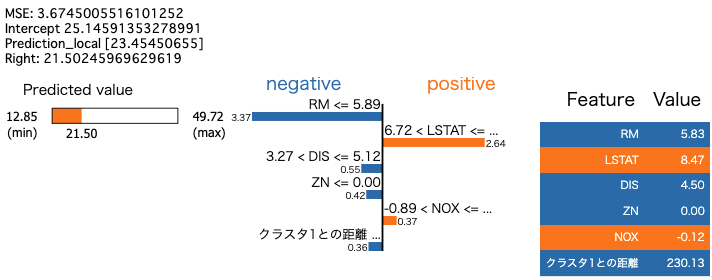

In [50]:
import lime
import lime.lime_tabular

def explain_importance(df):
    # データ分割
    X = df.drop(columns='MEDV', axis=1)
    y = df['MEDV']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

    # ランダム・フォレスト（回帰）
    model = RFR(max_depth=6, random_state=0, n_estimators=10)
    model.fit(X_train, y_train)

    # パラメータ
    RFR(bootstrap=True, criterion='mse', max_depth=6,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=10,
                          n_jobs=None, oob_score=False, random_state=0, verbose=0,
                          warm_start=False)
    # 予測
    y_pred = model.predict(X_test)
    # 評価
    mse = mean_squared_error(y_test, y_pred)**(0.5)
    print(f'MSE: {mse}')
    # 予測の判断根拠を示す（LIME）
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                      class_names=['MEDV'], verbose=True, mode='regression', random_state=0)
    # 解釈結果（予測結果への影響）を表示する
    j = 5
    exp = explainer.explain_instance(X_test.values[j], model.predict, num_features=6)
    exp.show_in_notebook(show_table=True)

# 実行
from IPython.display import Image
explain_importance(boston_df)
plt.savefig("newplot_lime.png")
Image("./newplot_lime.png")

# 特徴量エンジニアリング

In [10]:
# データ確認
boston_df.shape
boston_df.head().astype(str)
boston_df.describe().astype(str)

(506, 14)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.032369999999999996,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.9,5.33,36.2


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0,506.0
mean,3.6135235573122535,11.363636363636363,11.136778656126504,0.0691699604743083,0.5546950592885372,6.284634387351787,68.57490118577078,3.795042687747034,9.549407114624506,408.2371541501976,18.455533596837967,356.67403162055257,12.653063241106723,22.532806324110698
std,8.601545105332487,23.322452994515036,6.8603529408975845,0.2539940413404118,0.11587767566755611,0.7026171434153237,28.148861406903638,2.1057101266276104,8.707259384239377,168.53711605495926,2.164945523714446,91.29486438415779,7.141061511348571,9.19710408737982
min,0.00632,0.0,0.46,0.0,0.385,3.561,2.9,1.1296,1.0,187.0,12.6,0.32,1.73,5.0
25%,0.08204499999999999,0.0,5.19,0.0,0.449,5.8855,45.025,2.100175,4.0,279.0,17.4,375.3775,6.949999999999999,17.025
50%,0.25651,0.0,9.69,0.0,0.538,6.2085,77.5,3.2074499999999997,5.0,330.0,19.05,391.44,11.36,21.2
75%,3.6770824999999996,12.5,18.1,0.0,0.624,6.6235,94.07499999999999,5.1884250000000005,24.0,666.0,20.2,396.225,16.955000000000002,25.0
max,88.9762,100.0,27.74,1.0,0.871,8.78,100.0,12.1265,24.0,711.0,22.0,396.9,37.97,50.0


## 属性

- 説明変数  
    - CRIM：  
    町ごとの一人当たりの犯罪率  
    - ZN：  
    25,000平方フィートを超える区画にゾーニングされた住宅用地の割合。  
    - INDUS：  
    町ごとの非小売ビジネスエーカーの割合  
    - CHAS：（int）  
    チャールズリバーダミー変数（路が川に接している場合は1、それ以外の場合は0）  
    - NOX：  
    一酸化窒素濃度（1000万あたりのパーツ）[パーツ/ 10M]  
    - RM：  
    住居あたりの平均部屋数  
    - AGE：  
    1940年以前に建設された持ち家の割合  
    - DIS：  
    ボストンの5つの雇用センターまでの加重距離  
    - RAD：（int）  
    放射状高速道路へのアクセスの指標  
    - TAX：  
    全額-価値資産、10000ドルあたりの税率($/10k)  
    - PTRATIO：  
    町ごとの生徒と教師の比率  
    - B：  
    方程式B = 1000（Bk-0.63）^ 2の結果。ここで、Bkは町ごとの黒人の割合です。
    - LSTAT：  
    人口の％低いステータス  
  
- 目的変数：  
    - MEDV：  
    1000ドル'sの[k$]における持ち家の中央値  

## データ型、尺度

- 欠損値  
0件  
- データ型
  - object型  
  0件  
  - float型  
  12件  
  - int型  
  2件  

- 質的データ  
  - 名義尺度  
    - CHAS（2値）
  - 順序尺度  
    - なし
  
- 量的データ  
  - 間隔尺度  
    - RM
    - DIS
    - RAD
  - 比例尺度  
    - CRIM
    - ZN
    - INDUS
    - NOX
    - AGE
    - TAX
    - PTRATIO
    - B
    - MEDV

## 対応方針

- 対数変換（またはBox-Cox変換）  
  - MEDV  
  予測残差の正規分布性を期待する分析アルゴリズム（線形回帰など）を使用するため、必要と考える。  
  また、目的変数にマイナス値が既に含まれてしまっているため、Box-Cox変換を用いる。
  変換結果にマイナス値を含まれてしまい、線形モデルの評価時にエラーとなるため、Yeo-Johnson変換は行わない。　　
  
  
- 外れ値  
  - CRIM  
  （大きく外れた）外れ値（80）を含んでいる。犯罪率80%は疑わしい値。線形モデルを使用する（予定）のため、この外れ値を除去する。    
  
  
- スケーリング  
  - NOX, RM, DIS, PTRATIO, LSTAT, MEDV  
  （微妙な）外れ値の影響を軽減させたい  
  線形回帰に対しては有効でないと思われるが、非線形アルゴリズムをアンサンブルで使用する（予定）のため、有効であると考える。  
  
  
- ビニング  
  - RM
  目的変数に相関の高い「RM」を複雑にしたい。データセットがシンプルなため。
  
  
- 特徴量生成  
  - クラスタの重心からの距離  
  （まだ試してみたことがないため）実験的に効果検証してみる。  

## 正規分布への変換

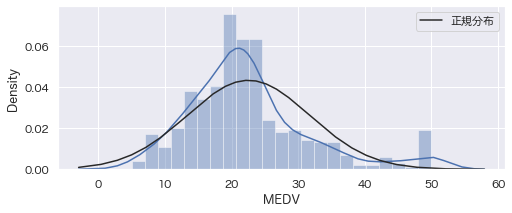

In [11]:
# 変換前の状態
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
plt.figure(figsize=[8,3])
sns.distplot(boston_df['MEDV'], kde=True, fit=norm, fit_kws={'label': '正規分布'}).grid()
plt.legend();

### Yeo-Johnson変換

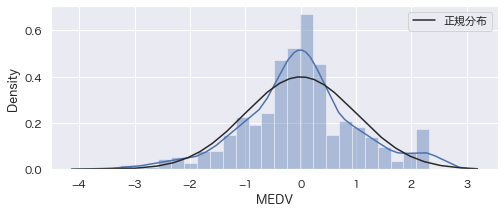

In [51]:
# Yeo-Johnson変換
from sklearn.preprocessing import PowerTransformer

yeo_johnson_df = boston_df.copy()
sk_yeojohnson = PowerTransformer(method='yeo-johnson') # インスタンス生成
yeojohnson_data = sk_yeojohnson.fit_transform(yeo_johnson_df[['MEDV']]) # 変換
yeo_johnson_df['MEDV'] = yeojohnson_data

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
plt.figure(figsize=[8,3])
sns.distplot(yeo_johnson_df['MEDV'], kde=True, fit=norm, fit_kws={'label': '正規分布'}).grid()
plt.legend();

ランダムフォレストには効果があったが、線形モデルには適用できない。評価の過程で目的変数に負値を扱えないため。

### Box-Cox変換 

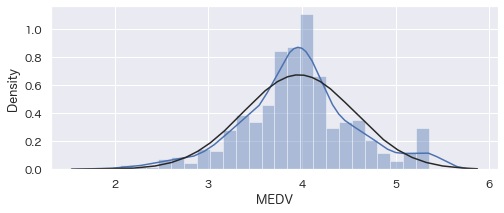

In [52]:
# Box-Cox変換 
from scipy.special import boxcox1p

boxcox_df = boston_df.copy()
lam=0.15
boxcox_df['MEDV'] = boxcox1p(boxcox_df['MEDV'], lam)

# 描画
plt.figure(figsize=[8,3])
sns.distplot(boxcox_df['MEDV'], kde=True, fit=norm, fit_kws={'label': '正規分布'}).grid();

（多少）分布の偏りが軽減された。しかし非線形モデルには逆効果だった。

## 外れ値

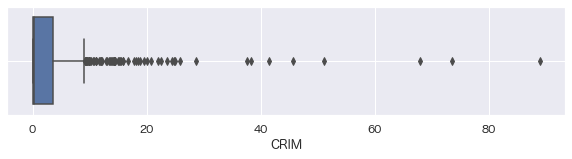

In [14]:
plt.figure(figsize=[10,2])
sns.boxplot(data=boston_df, x='CRIM').grid();

In [15]:
boston_df.shape
boston_df = boston_df[boston_df['CRIM']<40]
boston_df = boston_df.reset_index()
boston_df.shape

(506, 14)

(500, 15)

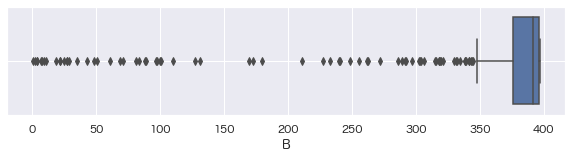

In [16]:
plt.figure(figsize=[10,2])
sns.boxplot(data=boston_df, x='B').grid();

In [17]:
boston_df.shape
boston_df = boston_df[boston_df['B']>10]
boston_df = boston_df.reset_index()
boston_df.shape

(500, 15)

(493, 16)

該当レコードを3行削除

## スケーリング

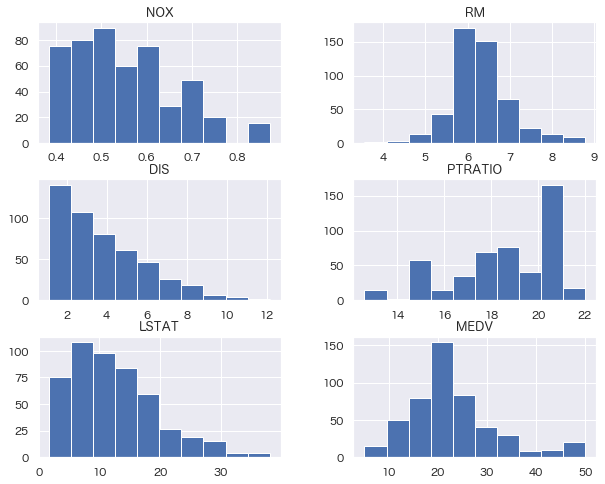

In [18]:
col = ['NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT', 'MEDV']
boston_df[col].hist(bins=10, figsize=(10,8));

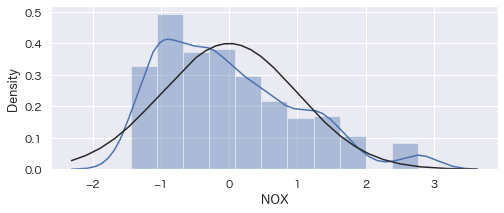

In [19]:
from sklearn.preprocessing import StandardScaler
# OK
scaler = StandardScaler()
boston_df['NOX'] = scaler.fit_transform(boston_df[['NOX']])

# 描画
plt.figure(figsize=[8,3])
sns.distplot(boston_df['NOX'], kde=True, fit=norm, fit_kws={'label': '正規分布'}).grid();

RM, DIS, PTRATIO, LSTAT, MEDVは、標準化しても精度に影響がなかったため、そのままとする。

## 特徴量生成

### クラスタリング、主成分分析

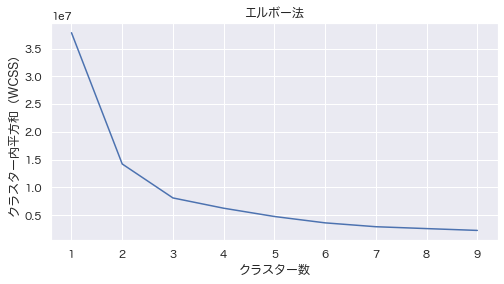

In [20]:
# クラスター数の探索（k-means++）
from sklearn.cluster import KMeans

def elbow(df):
    wcss = []
    for i in range(1, 10):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 30, random_state = 0)
        kmeans.fit(df.iloc[:, :])
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=[8,4])
    plt.plot(range(1, 10), wcss)
    plt.title('エルボー法')
    plt.xlabel('クラスター数')
    plt.ylabel('クラスター内平方和（WCSS）')
    plt.grid()
    plt.show()

# 実行
elbow(boston_df)

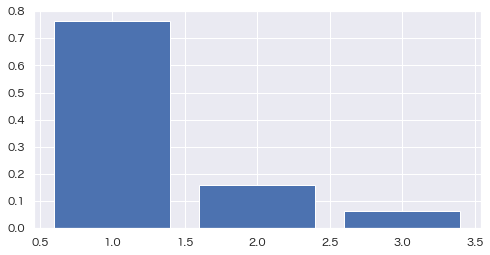

In [21]:
# 主成分分析
from sklearn.decomposition import PCA

# 寄与率
pca = PCA(n_components=3)
pca.fit(boston_df)
plt.figure(figsize=[8,4])
plt.grid()
plt.bar([n for n in range(1, len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_);

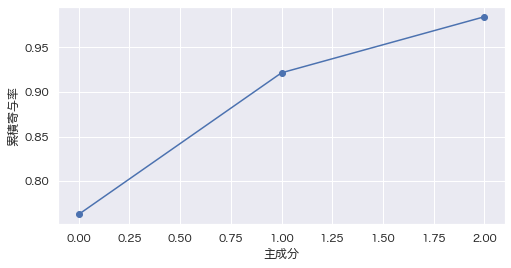

累積寄与率：　['0.98']


In [22]:
# 累積寄与率
contribution_ratio = pca.explained_variance_ratio_
accumulation_ratio = np.cumsum(contribution_ratio)
cc_ratio = np.hstack([0, accumulation_ratio])

plt.figure(figsize=[8,4])
plt.plot(accumulation_ratio, "-o")
plt.xlabel("主成分")
plt.ylabel("累積寄与率")
plt.grid()
plt.show()

contribution_ratios = pd.DataFrame(pca.explained_variance_ratio_)
contribution_ratios.round(decimals=2).astype('str').head()
print(f"累積寄与率：　{contribution_ratios[contribution_ratios.index<5].sum().round(decimals=2).astype('str').values}");

第３主成分までで寄与率は98%。クラスター数=3とする。

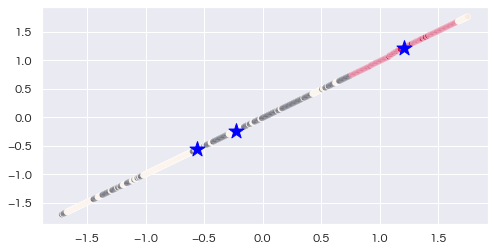

In [23]:
# クラスタリング（k-means）
from sklearn.preprocessing import StandardScaler

def clustering(df, num):
    sc = StandardScaler()
    sc.fit_transform(df)
    data_norm = sc.transform(df)

    cls = KMeans(n_clusters = num)
    result = cls.fit(data_norm)
    pred = cls.fit_predict(data_norm)

    plt.figure(figsize=[8, 4])
    sns.scatterplot(x=data_norm[:,0], y=data_norm[:,1], c=result.labels_)
    plt.scatter(result.cluster_centers_[:,0], result.cluster_centers_[:,1], s=250, marker='*', c='blue')
    plt.grid('darkgray')
    plt.show()

# 実行
clustering(boston_df, 3)

うまく分割できない。主成分分析を行う。

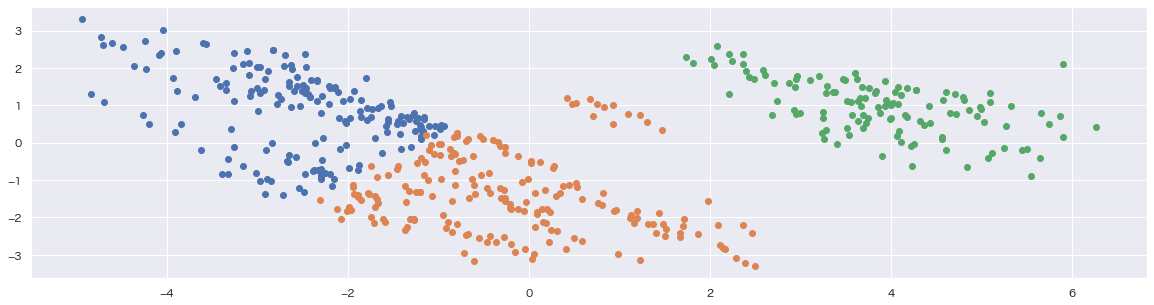

In [24]:
## クラスタリング（k-means）＋主成分分析
from sklearn.decomposition import PCA

def cross(df, num):
    df_cls = df.copy()
    sc = StandardScaler()
    clustering_sc = sc.fit_transform(df_cls)
    
    # n_clusters：クラスター数
    kmeans = KMeans(n_clusters=num, random_state=42)
    clusters = kmeans.fit(clustering_sc)
    df_cls['cluster'] = clusters.labels_

    x = clustering_sc
    # n_components：削減結果の次元数
    pca = PCA(n_components=num)
    pca.fit(x)
    x_pca = pca.transform(x)
    pca_df = pd.DataFrame(x_pca)
    pca_df['cluster'] = df_cls['cluster']

    for i in df_cls['cluster'].unique():
       tmp = pca_df.loc[pca_df['cluster'] == i]
       plt.scatter(tmp[0], tmp[1])
    plt.grid()
    plt.show()

# 実行
cross(boston_df, 3)

今度はうまく分割できた。  
３つのクラスタと、その重心からの距離を算出する。

In [25]:
# 重心からの距離
def get_center_distance(df):
    num_cluster=3 # cluster数
    clusters = KMeans(n_clusters=num_cluster, random_state = 42)
    clusters.fit(df)
    centers = clusters.cluster_centers_

    columns = df.columns
    clust_features = pd.DataFrame(index = df.index)
    for i in range(len(centers)):
        clust_features['クラスタ' + str(i + 1) + 'との距離'] = (df[columns] - centers[i]).applymap(abs).apply(sum, axis = 1)
    return clust_features

# 実行
clust_features = get_center_distance(boston_df)
boston_df[clust_features.columns] = clust_features
boston_df.head()

,level_0,index,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,クラスタ1との距離,クラスタ2との距離,クラスタ3との距離
0,0,0,0,18,2,0,-0,7,65,4,1,296,15,397,5,24,280,601,1404
1,1,1,0,0,7,0,-1,6,79,5,2,242,18,397,9,22,318,667,1411
2,2,2,0,0,7,0,-1,7,61,5,2,242,18,393,4,35,332,647,1442
3,3,3,0,0,2,0,-1,7,46,6,3,222,19,395,3,33,372,664,1481
4,4,4,0,0,2,0,-1,7,54,6,3,222,19,397,5,36,364,664,1473


効果はありそうなため、このまま残すことにする。

## オーバーサンプリング

In [26]:
# SMOTE
from imblearn.over_sampling import SMOTE

column = 'CHAS'
sm = SMOTE(random_state=42)
X = boston_df.drop(columns=column, axis=1)
y = boston_df[column]
X_sample, Y_sample = sm.fit_resample(X, y)

over_sampling = pd.DataFrame()
over_sampling = X_sample
over_sampling[column] = Y_sample

value_counts = over_sampling[column].value_counts()

df = pd.DataFrame()
df['ラベル'] = value_counts.index
df['件数'] = value_counts.values
ratio=[]
ratio.append((value_counts.values[0] / len(over_sampling[column]) * 100).round(decimals=2).astype('str'))
ratio.append((value_counts.values[1] / len(over_sampling[column]) * 100).round(decimals=2).astype('str'))
df['割合'] = [f'{ratio[0]}%', f'{ratio[1]}%']
print(f"全レコード数：{len(over_sampling[column])}")
df

# boston_df = over_sampling

全レコード数：916


,ラベル,件数,割合
0,1,458,50.0%
1,0,458,50.0%


「CHAS」に対するオーバーサンプリングは、ランダムフォレストに対しては効果がある。その際「重心からの距離」がない方が精度が良い。   
ただし、線形モデルに対しては、大幅な精度の悪化を招く。一旦、不採用とする。  

## カウント・エンコーディング

{0: 458, 1: 35}

,CHAS,CHASカウント
0,0,458
1,0,458
2,0,458
3,0,458
4,0,458


<AxesSubplot:xlabel='CHASカウント', ylabel='Density'>

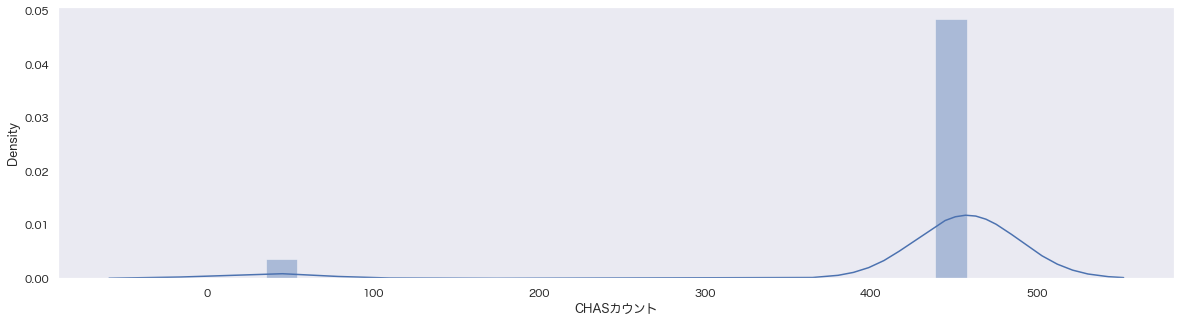

In [27]:
count_map = boston_df['CHAS'].value_counts().to_dict()
count_map

df = boston_df.copy()
df['CHASカウント'] = df['CHAS'].map(count_map)
df[['CHAS', 'CHASカウント']].head()
df = df.drop(columns='CHAS', axis=1)
sns.distplot(df['CHASカウント'])

# boston_df['CHASカウント'] = df['CHASカウント']

CAHSは住宅価格帯が異なるため、影響があると思ったが、得に影響はなかった。  
出現頻度を学習させ、大小を明確にすれば影響が出ると考えたが、むしろ精度が悪化した。  
一旦、このカウント・エンコーディングを採用するかは保留とする。  

# 再評価

In [28]:
# 実行
rfr_model, y_test, y_pred = learning(RFR(random_state=42), boston_df)

決定係数（R2） =  0.924
平均絶対誤差（MAE） =  1.761
平均二乗誤差（MSE） =  5.588
対数平均二乗誤差（MSLE） =  0.018
平均二乗平方根誤差（RMSE） =  2.364
対数平方平均二乗誤差（RMSLE） =  0.134


In [29]:
# 線形回帰（重回帰）
from sklearn.linear_model import LinearRegression as LR
rfr_model, y_test, y_pred = learning(LR(), boston_df)

決定係数（R2） =  0.811
平均絶対誤差（MAE） =  2.919
平均二乗誤差（MSE） =  13.928
対数平均二乗誤差（MSLE） =  0.048
平均二乗平方根誤差（RMSE） =  3.732
対数平方平均二乗誤差（RMSLE） =  0.219


In [30]:
# 線形モデル
from sklearn.linear_model import Ridge
rfr_model, y_test, y_pred = learning(Ridge(), boston_df)

決定係数（R2） =  0.81
平均絶対誤差（MAE） =  2.924
平均二乗誤差（MSE） =  13.977
対数平均二乗誤差（MSLE） =  0.048
平均二乗平方根誤差（RMSE） =  3.739
対数平方平均二乗誤差（RMSLE） =  0.219


In [31]:
# 線形モデル
from sklearn.linear_model import Lasso
rfr_model, y_test, y_pred = learning(Lasso(), boston_df)

決定係数（R2） =  0.745
平均絶対誤差（MAE） =  3.172
平均二乗誤差（MSE） =  18.792
対数平均二乗誤差（MSLE） =  0.042
平均二乗平方根誤差（RMSE） =  4.335
対数平方平均二乗誤差（RMSLE） =  0.204


In [32]:
# 線形回帰（重回帰）
from sklearn.linear_model import ElasticNet
rfr_model, y_test, y_pred = learning(ElasticNet(), boston_df)

決定係数（R2） =  0.759
平均絶対誤差（MAE） =  3.112
平均二乗誤差（MSE） =  17.745
対数平均二乗誤差（MSLE） =  0.04
平均二乗平方根誤差（RMSE） =  4.212
対数平方平均二乗誤差（RMSLE） =  0.201


全体的に精度の向上が見られる。

# 特徴選択

## 特徴量重要度

In [33]:
# 実行
imp_df = rfr_importance(boston_df)
imp_df = imp_df.sort_values(by='重要度', ascending=False).reset_index().set_index("項目名")
imp_df = imp_df.drop(columns="index", axis=1)
imp_df
# sns.barplot(x="重要度", y="項目名", data=imp_df)

平均二乗平方根誤差（RMSE） = 3.399


,重要度
項目名,
RM,0.504
LSTAT,0.302
DIS,0.072
CRIM,0.019
クラスタ1との距離,0.015
NOX,0.014
TAX,0.01
PTRATIO,0.01
クラスタ2との距離,0.009


[15:44:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




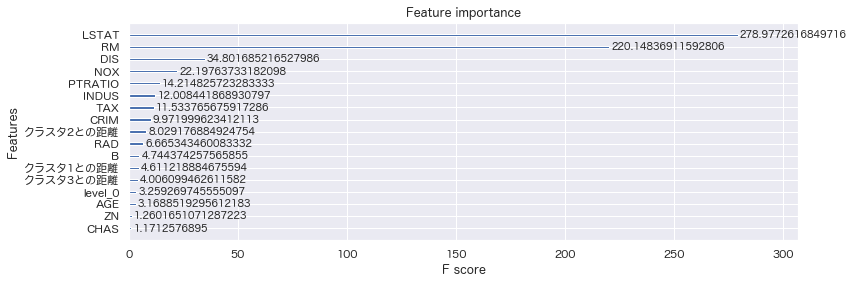

In [34]:
# 実行
boost_importance(boston_df)

スコア： 5.537
選択項目数： 12、除外項目数： 6


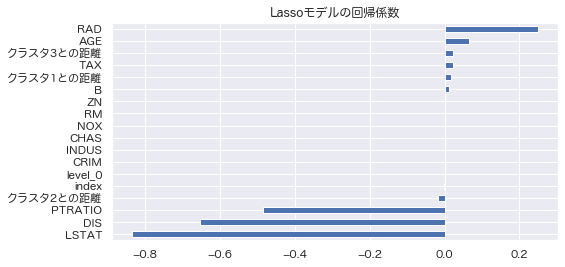

In [35]:
# 実行
linear_importance(boston_df)

In [36]:
explain_importance(boston_df)

MSE: 3.6745005516101252
Intercept 25.14591353278991
Prediction_local [23.45450655]
Right: 21.50245969629619


# 結果を踏まえて再評価

In [37]:
boston_df.head()

,level_0,index,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,クラスタ1との距離,クラスタ2との距離,クラスタ3との距離
0,0,0,0,18,2,0,-0,7,65,4,1,296,15,397,5,24,280,601,1404
1,1,1,0,0,7,0,-1,6,79,5,2,242,18,397,9,22,318,667,1411
2,2,2,0,0,7,0,-1,7,61,5,2,242,18,393,4,35,332,647,1442
3,3,3,0,0,2,0,-1,7,46,6,3,222,19,395,3,33,372,664,1481
4,4,4,0,0,2,0,-1,7,54,6,3,222,19,397,5,36,364,664,1473


In [38]:
features = boston_df.drop(columns=['INDUS', 'CRIM', 'level_0', 'index', 'クラスタ3との距離']).columns
features

Index(['ZN', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B',
       'LSTAT', 'MEDV', 'クラスタ1との距離', 'クラスタ2との距離'],
      dtype='object')

In [39]:
# 実行
rfr_model, y_test, y_pred = learning(RFR(random_state=42), boston_df[features])

決定係数（R2） =  0.929
平均絶対誤差（MAE） =  1.712
平均二乗誤差（MSE） =  5.248
対数平均二乗誤差（MSLE） =  0.017
平均二乗平方根誤差（RMSE） =  2.291
対数平方平均二乗誤差（RMSLE） =  0.129


In [40]:
# 線形回帰（重回帰）
from sklearn.linear_model import LinearRegression as LR
rfr_model, y_test, y_pred = learning(LR(), boston_df[features])

決定係数（R2） =  0.827
平均絶対誤差（MAE） =  2.803
平均二乗誤差（MSE） =  12.766
対数平均二乗誤差（MSLE） =  0.036
平均二乗平方根誤差（RMSE） =  3.573
対数平方平均二乗誤差（RMSLE） =  0.189


In [41]:
# 線形モデル
from sklearn.linear_model import Ridge
rfr_model, y_test, y_pred = learning(Ridge(), boston_df[features])

決定係数（R2） =  0.827
平均絶対誤差（MAE） =  2.799
平均二乗誤差（MSE） =  12.736
対数平均二乗誤差（MSLE） =  0.036
平均二乗平方根誤差（RMSE） =  3.569
対数平方平均二乗誤差（RMSLE） =  0.189


In [42]:
# 線形モデル
from sklearn.linear_model import Lasso
rfr_model, y_test, y_pred = learning(Lasso(), boston_df[features])

決定係数（R2） =  0.767
平均絶対誤差（MAE） =  3.124
平均二乗誤差（MSE） =  17.171
対数平均二乗誤差（MSLE） =  0.032
平均二乗平方根誤差（RMSE） =  4.144
対数平方平均二乗誤差（RMSLE） =  0.179


In [43]:
# 線形回帰（重回帰）
from sklearn.linear_model import ElasticNet
rfr_model, y_test, y_pred = learning(ElasticNet(), boston_df[features])

決定係数（R2） =  0.773
平均絶対誤差（MAE） =  3.073
平均二乗誤差（MSE） =  16.698
対数平均二乗誤差（MSLE） =  0.031
平均二乗平方根誤差（RMSE） =  4.086
対数平方平均二乗誤差（RMSLE） =  0.176


新宿の例といい、犯罪率は住宅価格との関係はないのかもしれない。  
CHASは「０⇆１」で住宅価格が異なっていたため、影響はあると思われたが、「CHAS」単体では影響があまりなかった。

# 結果出力

In [44]:
boston_df[features].to_csv('./boston_processed.csv', index=0)